In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import joblib

In [2]:
print(tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

2.16.2
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
df = pd.read_csv('data.csv')
df.head()

,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,y18,z18,x19,y19,z19,x20,y20,z20,handedness,label
0,0.066402,0.714774,-5.149332e-07,0.110267,0.567437,-0.007399,0.177215,0.406313,-0.023405,0.211647,...,0.703239,-0.120772,0.228314,0.706775,-0.112544,0.189190,0.687547,-0.109797,0,1
1,0.067964,0.717013,-5.303769e-07,0.108681,0.570630,-0.008028,0.177440,0.409624,-0.023619,0.214079,...,0.707820,-0.117026,0.232774,0.712451,-0.107594,0.194152,0.693200,-0.103903,0,1
2,0.073413,0.720001,-5.408315e-07,0.113233,0.572339,-0.007361,0.182355,0.412784,-0.022473,0.218962,...,0.716653,-0.113614,0.238621,0.721244,-0.103292,0.199771,0.702700,-0.099165,0,1
3,0.079909,0.720517,-4.687542e-07,0.113828,0.574180,-0.010201,0.184310,0.419570,-0.026842,0.225137,...,0.723539,-0.112793,0.246905,0.729405,-0.101743,0.209507,0.711692,-0.096743,0,1
4,0.085028,0.720623,-4.441287e-07,0.117068,0.576235,-0.010575,0.186558,0.418234,-0.025969,0.225809,...,0.723339,-0.105736,0.253043,0.730022,-0.094346,0.217032,0.713488,-0.088924,0,1


In [4]:
# Count occurrences of each label
label_counts = df['label'].value_counts().sort_index()

# Map label numbers to names (update as per your labels)
label_names = {0: 'Thumbs Down', 1: 'Thumbs Up', 2: 'Other'}

# Print counts with labels
for label, count in label_counts.items():
    print(f"{label_names.get(label, 'Unknown')} (label={label}): {count} samples")

Thumbs Down (label=0): 4614 samples
Thumbs Up (label=1): 4561 samples
Other (label=2): 4540 samples


In [5]:
X = df.drop('label', axis=1).values  # all columns except label
y = df['label'].values

In [6]:
# Scale features for better training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
y_encoded = to_categorical(y, num_classes=3)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Build multi-class MLP model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 output classes
])

/opt/anaconda3/envs/tf_arm/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,771 (65.51 KB)

 Trainable params: 16,771 (65.51 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=32)

Epoch 1/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7945 - loss: 0.6030 - val_accuracy: 0.9544 - val_loss: 0.1186
Epoch 2/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9068 - loss: 0.4037 - val_accuracy: 0.9705 - val_loss: 0.1076
Epoch 3/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9411 - loss: 0.2322 - val_accuracy: 0.9810 - val_loss: 0.0647
Epoch 4/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9552 - loss: 0.1473 - val_accuracy: 0.9843 - val_loss: 0.0671
Epoch 5/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9538 - loss: 0.1532 - val_accuracy: 0.9778 - val_loss: 0.0731
Epoch 6/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9547 - loss: 0.1503 - val_accuracy: 0.9803 - val_loss: 0.0721
Epoch 7/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9520 - loss: 0.1664 - val_accuracy: 0.9676 - val_loss: 0.1181
Epoch 8/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9516 - loss: 0.1789 - val_accu

In [13]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9725 - loss: 0.2287

Test Accuracy: 97.19%


In [14]:
# Save the model and scaler
model.save('thumbs_mlp_model.keras')
import joblib
joblib.dump(scaler, 'scaler.save')

print("Model and scaler saved.")

Model and scaler saved.


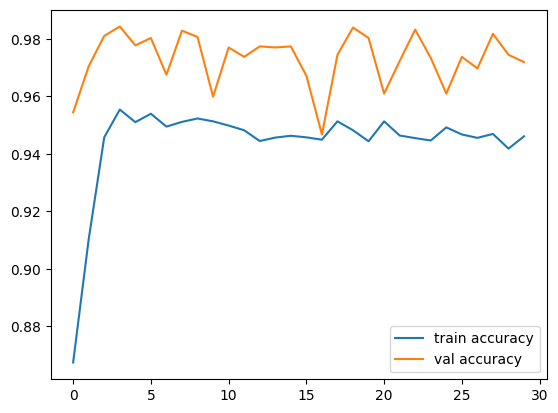

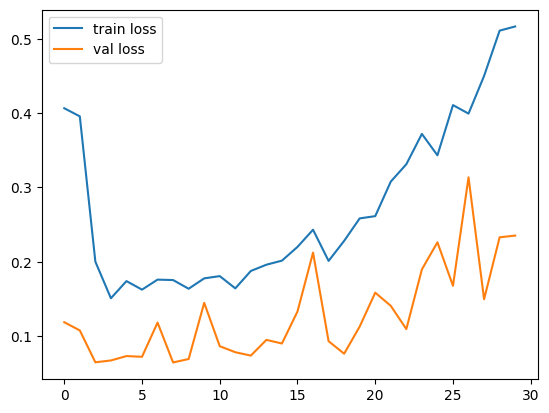

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()